# Background

In the National Football League (NFL), athletes exhibit a remarkable range of physical attributes tailored to the demands of their positions. Every year, the NFL Combine collects physical and performance data from new athletes declaring for the NFL draft. Scouts use this data to further evaluate player prospects beyond their on-field performances.

In this post, I will investigate the effectiveness of K-means clustering in identifying player positions using NFL Combine data from 2000 to 2018. Additionally, I will conduct several tests to investigate annual trends in the Cone Drill.

# Exploratory Analysis
The following code will be run using a Python 3 kernel in Jupyter Notebook. We'll start by loading in the dataset and libraries below!

In [23]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# Load NFL Combine data from 2000-2018
df = pd.read_csv("combine_data_since_2000_PROCESSED_2018-04-26.csv", index_col="Player")


First, let's take a look at the raw data.



In [24]:
df.shape

(6218, 15)

(6218, 15)

In [25]:
# Print the first 6 rows
df.head(6)

,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick
Player,,,,,,,,,,,,,,,
John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0
Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0
Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0
Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN
Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0
Jake Arians,K,70,202,NaN,NaN,NaN,NaN,NaN,NaN,2000,arianjak01,0.0,NaN,NaN,NaN


We have 15 fields for 6218 players in our dataset, including information on their draft outcome. Some players have missing information, and several fields that are not of interest to us...

Let's group similar player positons together (i.e., a linebacker LB and an inside linebacker ILB). This will be useful later in our cluster analysis.

In [26]:
# Create a dictonary to categorize player positions in the dataset
position_mapping = {
    "Quarterback": ["QB"],
    "Receiver": ["WR"],
    "Ball-Carrier": ["RB", "FB"],
    "Tight-End": ["TE"],
    "Secondary": ["S", "SS", "FS", "CB", "DB"],
    "Linebacker": ["ILB", "OLB", "Edge", "LB"],
    "D-Line": ["DE", "DT", "NT"],
    "O-Line": ["OT", "OG", "C", "G", "OL"],
    "Special": ["K", "P", "LS"]
}

# Create a function to map categorized positions back to players
def map_position(pos):
    for position, values in position_mapping.items():
        if pos in values:
            return position
    return "Unknown"

# Reformat Position
df["Position"] = df["Pos"].apply(map_position)

Now let's drop those pesky fields.



In [27]:
# Drop unnecessary fields
df.drop(columns=["Pos", "AV", "Pfr_ID"], inplace=True)

Upon investigating the data source, it is safe for us to assume players with NaN values for Team, Round, and Pick went undrafted. We will alias these players easier to make them easier to identify. As for the players with missing combine metrics, we will remove them altogether.

In [28]:
# Replace NaN values for undrafted players
df.loc[df["Team"].isna(), "Team"] = "Undrafted"
df.loc[df["Round"].isna(), "Round"] = 0
df.loc[df["Pick"].isna(), "Pick"] = 0

# Appropriate integer fields
df['Round'] = df['Round'].astype(int)
df['Pick'] = df['Pick'].astype(int)

# Drop players from dataset with missing combine metrics
df.dropna(inplace=True)

# Rename select fields
df = df.rename(columns={
    'Ht': 'Height',
    'Wt': 'Weight',
    'Vertical': 'Vert',
    'BenchReps': 'Bench',
    'BroadJump': 'Jump'
})

# View the new dataframe
df.head(6)

,Height,Weight,Forty,Vert,Bench,Jump,Cone,Shuttle,Year,Team,Round,Pick,Position
Player,,,,,,,,,,,,,
Darnell Alford,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,Kansas City Chiefs,6,188,O-Line
Corey Atkins,72,237,4.72,31.0,21.0,112.0,7.96,4.39,2000,Undrafted,0,0,Linebacker
Reggie Austin,69,175,4.44,35.0,17.0,119.0,7.03,4.14,2000,Chicago Bears,4,125,Secondary
Mark Baniewicz,78,312,5.34,28.0,20.0,96.0,7.72,4.73,2000,Undrafted,0,0,O-Line
Rashidi Barnes,72,208,4.62,35.0,10.0,114.0,6.92,4.32,2000,Cleveland Browns,7,225,Secondary
David Barrett,70,199,4.44,37.5,16.0,116.0,6.81,4.04,2000,Arizona Cardinals,4,102,Secondary


Let's take one last look at a summary of the new dataframe.



In [29]:
df.describe()

,Height,Weight,Forty,Vert,Bench,Jump,Cone,Shuttle,Year,Round,Pick
count,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000
mean,73.992721,252.087348,4.811584,32.598267,21.091854,113.190295,7.305719,4.408548,2009.374350,2.497400,74.529983
std,2.675779,45.882206,0.321231,4.270008,6.395231,9.491045,0.431420,0.269871,5.253415,2.441353,79.212391
min,65.000000,166.000000,4.260000,19.500000,2.000000,82.000000,6.280000,3.750000,2000.000000,0.000000,0.000000
25%,72.000000,210.000000,4.550000,29.500000,17.000000,107.000000,6.970000,4.200000,2005.000000,0.000000,0.000000
50%,74.000000,247.000000,4.730000,33.000000,21.000000,114.000000,7.220000,4.370000,2010.000000,2.000000,52.000000
75%,76.000000,300.000000,5.060000,35.500000,25.000000,120.000000,7.590000,4.590000,2014.000000,5.000000,137.000000
max,81.000000,370.000000,6.000000,45.500000,45.000000,139.000000,9.040000,5.560000,2018.000000,7.000000,259.000000


We are left with 2885 player records to evaluate.

# Variable Correlation
Next, we'll investigate relationships between numeric variables in the dataset by creating a correlation heatmap.


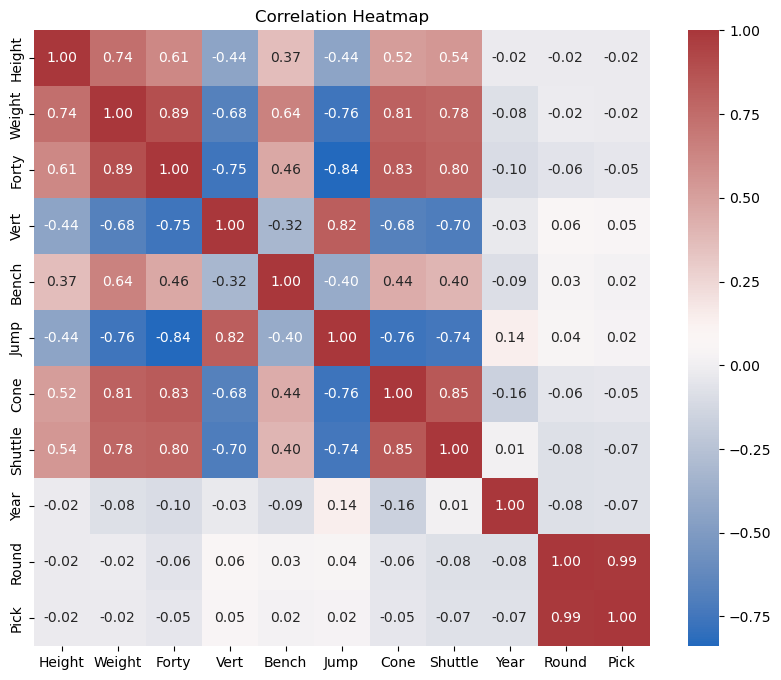

In [30]:
# Create a copy of the dataframe
df_numeric = df.copy()

# Drop 'team' and 'position' columns from the copied dataframe
df_numeric.drop(['Team', 'Position'], axis=1, inplace=True)

# Calculate a correlation matrix
correlation_matrix = df_numeric.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.color_palette("vlag", as_cmap=True), fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

Many of these correlations seem intuitive. We might expect a player's weight to be positively correlated with their 40-Yard Dash time, which we see with a correlation coefficient r of 0.89 (i.e., heavier players often take longer to complete this drill). It's also reasonable that a player's standing jump would be negatively correlated with their Forty-Yard Dash time. Players who complete the dash in less time (faster) are more likely to jump higher than heavier, slower players. We will circle back to these correlations in a bit for further analysis.

# Cluster Analysis
Let's explore different player types within the dataset using K-means clustering. To decide on an optimal number of clusters, we'll develop a function that visualizes inertia across different values of k. An elbow point on this plot will represent a significant decrease in inertia relative to increasing k-values, indicating the optimal number of clusters where adding more clusters does not significantly reduce inertia.

In [31]:
# Create a function to plot the inertias of k for clustering
def optimize_k(data, max_k):
    means=[]
    inertias=[]

    for k in range(1, max_k):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    # Elbow plot to identify optimal k-value
    fig=plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()


Now that we've created an inertia function, we can test it by first clustering on all numeric fields in the dataset. This process will effectively create k player clusters characterized by similar performance metrics among their members.

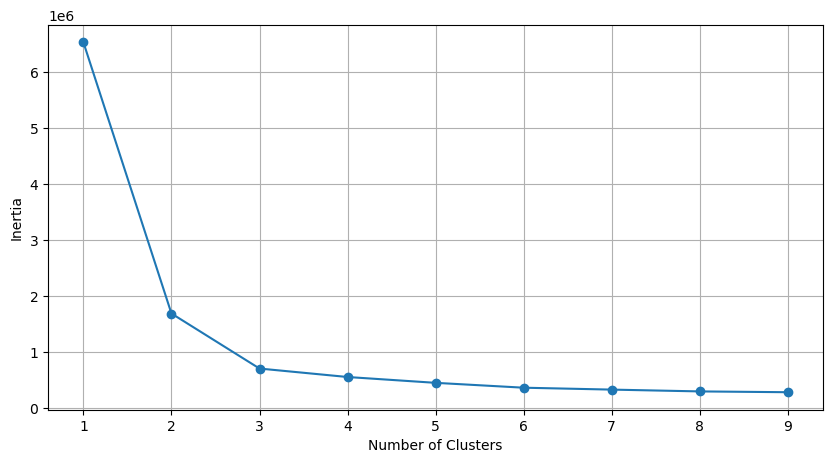

In [32]:
# Determine k for clustering on all numeric fields in the data
optimize_k(df[["Height", "Weight", "Forty", "Vert", "Bench", "Jump", "Cone", "Shuttle"]], 10)

Based on the elbow plot above, we will select k=3 for our first K-means clustering on all numeric fields.



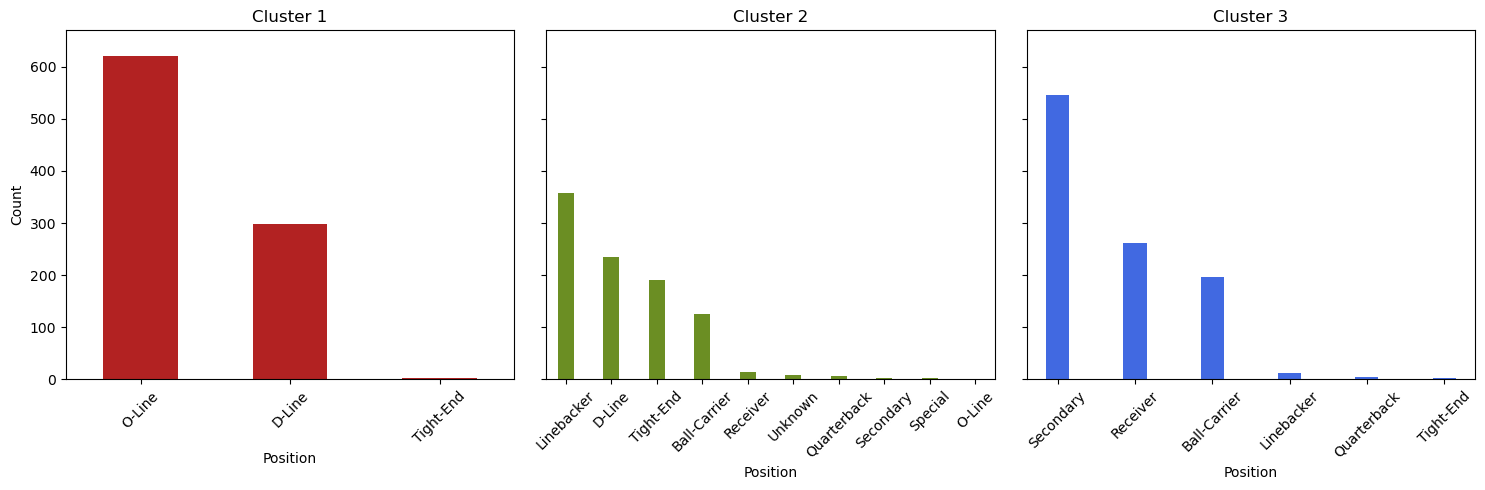

In [33]:
# Let k=3 and cluster on all numeric fields
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[["Height", "Weight", "Forty", "Vert", "Bench", "Jump", "Cone", "Shuttle"]])
df["kmeans_3_all"]=kmeans.labels_

# Split up clusters for plotting
cluster_1 = df[df["kmeans_3_all"]==1]
cluster_2 = df[df["kmeans_3_all"]==0]
cluster_3 = df[df["kmeans_3_all"]==2]

# Identify the max player count for positions across all clusters
max_count = max(cluster_1['Position'].value_counts().max(), cluster_2['Position'].value_counts().max(), cluster_3['Position'].value_counts().max())
# Set shared y-axis height
y_axis_limit = max_count + 50
# Create empty plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Format cluster 1 subplot
cluster_1['Position'].value_counts().plot(kind='bar', color='firebrick', ax=axes[0], width=0.50)
axes[0].set_title('Cluster 1')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, y_axis_limit)
axes[0].tick_params(axis='x', rotation=45)

# Format cluster 2 subplot
cluster_2['Position'].value_counts().plot(kind='bar', color='olivedrab', ax=axes[1], width=0.35)
axes[1].set_title('Cluster 2')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, y_axis_limit)
axes[1].tick_params(axis='x', rotation=45)

# Format cluster 3 subplot
cluster_3['Position'].value_counts().plot(kind='bar', color='royalblue', ax=axes[2], width=0.30)
axes[2].set_title('Cluster 3')
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Count')
axes[2].set_ylim(0, y_axis_limit)
axes[2].tick_params(axis='x', rotation=45)

# Display subplots
plt.tight_layout()
plt.show()

As specified, the 2885 player-records have been clustered on all numeric fields (Height, Weight, Forty, Bench...) and assigned to one of three groups. The plots above show the distribution of player position counts within each cluster.

Cluster 1 contains mostly offensive and defensive linemen, characterized by their substantial stature and weight. These players exhibit impressive power and explosiveness, making them formidable forces in the trenches.

Cluster 2 contains a majority of skilled players like recievers, defensive backs, and running backs. Known for their agility, speed, and explosive bursts, these athletes excel in making quick, decisive movements on the field.

Cluster 3 presents a diverse mix of player types, including linebackers, defensive ends, and tight ends. Combining elements from both Cluster 1 and Cluster 2, these players showcase a blend of strength, agility, and versatility, making them crucial assets in various facets of the game.

Rather than looking at all numeric variables, let's narrow down our selection to two highly correlated variables, like Forty-Yard Dash and Weight (r=0.89). Similar to our last procedure, we'll have to determine a new value of k to cluster on a new variable set.

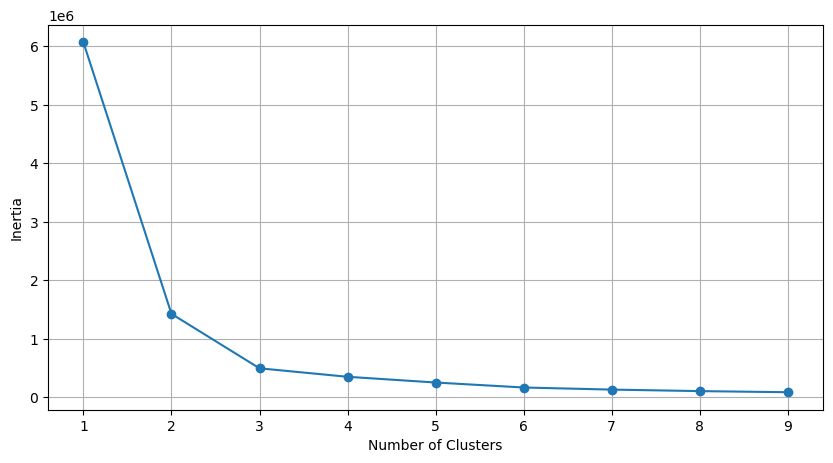

In [34]:
# Determine k for clustering on Forty vs Weight
optimize_k(df[["Weight", "Forty"]], 10)

As specified, the 2885 player-records have been clustered on all numeric fields (Height, Weight, Forty, Bench...) and assigned to one of three groups. The plots above show the distribution of player position counts within each cluster.

**Cluster 1** contains mostly offensive and defensive linemen, characterized by their substantial stature and weight. These players exhibit impressive power and explosiveness, making them formidable forces in the trenches.

**Cluster 2** contains a majority of skilled players like recievers, defensive backs, and running backs. Known for their agility, speed, and explosive bursts, these athletes excel in making quick, decisive movements on the field.

**Cluster 3** presents a diverse mix of player types, including linebackers, defensive ends, and tight ends. Combining elements from both Cluster 1 and Cluster 2, these players showcase a blend of strength, agility, and versatility, making them crucial assets in various facets of the game.

Rather than looking at all numeric variables, let's narrow down our selection to two highly correlated variables, like Forty-Yard Dash and Weight (r=0.89). Similar to our last procedure, we'll have to determine a new value of k to cluster on a new variable set.

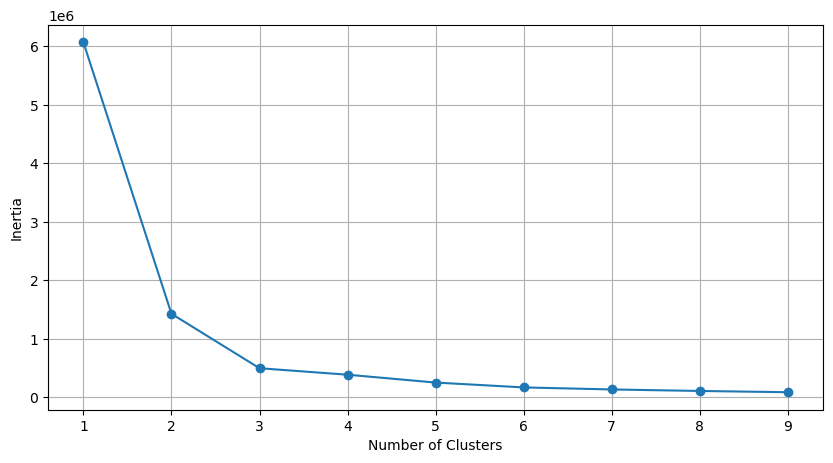

In [35]:
# Determine k for clustering on Forty vs Weight
optimize_k(df[["Weight", "Forty"]], 10)

Based on the elbow plot above, we will again select k=3 for clustering on Forty-Yard Dash (Forty) vs Weight.



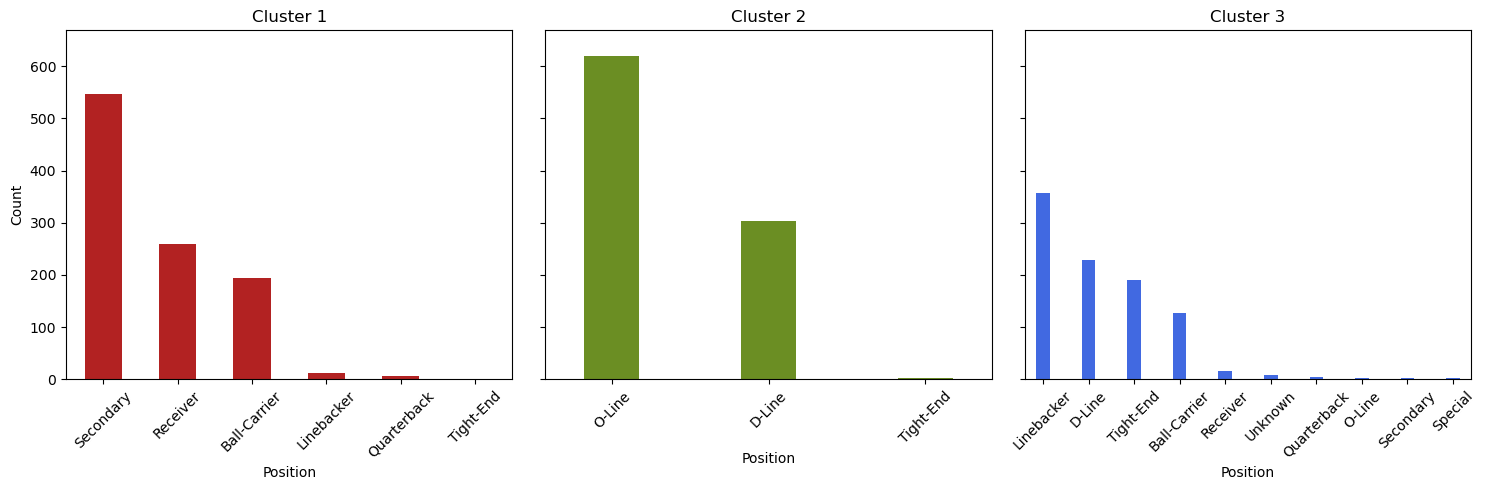

In [36]:
# Let k=3 and cluster on forty vs weight
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[["Weight", "Forty"]])
df["kmeans_3_Wt_Fty"]=kmeans.labels_

# Split up clusters for plotting
cluster_1 = df[df["kmeans_3_Wt_Fty"]==2]
cluster_2 = df[df["kmeans_3_Wt_Fty"]==0]
cluster_3 = df[df["kmeans_3_Wt_Fty"]==1]

# Identify the max player count for positions across all clusters
max_count = max(cluster_1['Position'].value_counts().max(), cluster_2['Position'].value_counts().max(), cluster_3['Position'].value_counts().max())
# Set shared y-axis height
y_axis_limit = max_count + 50
# Format empty plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Format cluster 1 subplot
cluster_1['Position'].value_counts().plot(kind='bar', color='firebrick', ax=axes[0], width=0.50)
axes[0].set_title('Cluster 1')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, y_axis_limit)
axes[0].tick_params(axis='x', rotation=45)

# Format cluster 2 subplot
cluster_2['Position'].value_counts().plot(kind='bar', color='olivedrab', ax=axes[1], width=0.35)
axes[1].set_title('Cluster 2')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, y_axis_limit)
axes[1].tick_params(axis='x', rotation=45)

# Format cluster 3 subplot
cluster_3['Position'].value_counts().plot(kind='bar', color='royalblue', ax=axes[2], width=0.30)
axes[2].set_title('Cluster 3')
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Count')
axes[2].set_ylim(0, y_axis_limit)
axes[2].tick_params(axis='x', rotation=45)

# Display plots
plt.tight_layout()
plt.show()

The distribution of player positions within these new Forty-vs-Weight clusters is nearly identical to that of our clusters on all numeric fields. Now that we've narrowed our focus to two dimensions, we can generate a scatter plot comparing Forty-Yard Dash and Weight. We'll color-code these points based on their respective clusters.

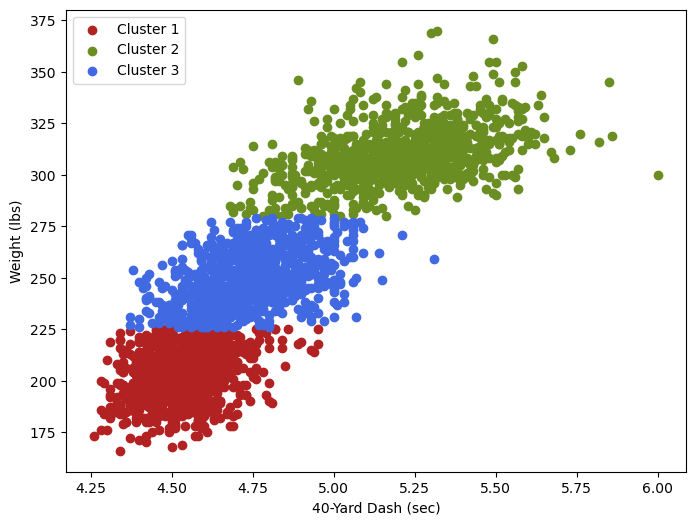

In [37]:
# Scatter plot of Forty vs Weight (3 clusters)
fig, ax = plt.subplots(figsize=(8, 6))

# Define custom colors for the clusters
colors = ['firebrick', 'olivedrab', 'royalblue']

# Function to assign clusters with proper colors in scatter plot
def f(i):
    return [2, 0, 1][i % 3]

# Scatter plot with custom colors for each cluster
for i, color in enumerate(colors):
    cluster_data = df[df["kmeans_3_Wt_Fty"] == f(i)]  # Filter data for each cluster
    ax.scatter(x=cluster_data["Forty"], y=cluster_data["Weight"], c=color, label=f'Cluster {i+1}')

ax.set_xlabel("40-Yard Dash (sec)")
ax.set_ylabel("Weight (lbs)")
ax.legend()  # Show legend for cluster colors

plt.show()

This plot provides a visual representation of our clusters in the context of Forty-Yard Dash times and Weight. As expected, the clusters are clearly delineated: Cluster 1 points (Power Positions) are predominantly positioned towards the top right on the plot, Cluster 2 points (Agile Players) occupy the bottom left, and Cluster 3 points (Hybrid Builds) are situated in the middle.

# Cone Drill Regression Analysis
As promised, it's time to shift our focus back to the correlation heatmap above. Considering annual trends, we observed that Year shared its strongest correlation with Cone Drill (r = -0.16). While this correlation is relatively modest, it does raise a question: Has the average time to complete the Cone Drill seen a significant decrease since 2000?

Before answering this question, we can investigate the average Cone Drill speed year-over-year with a line chart.

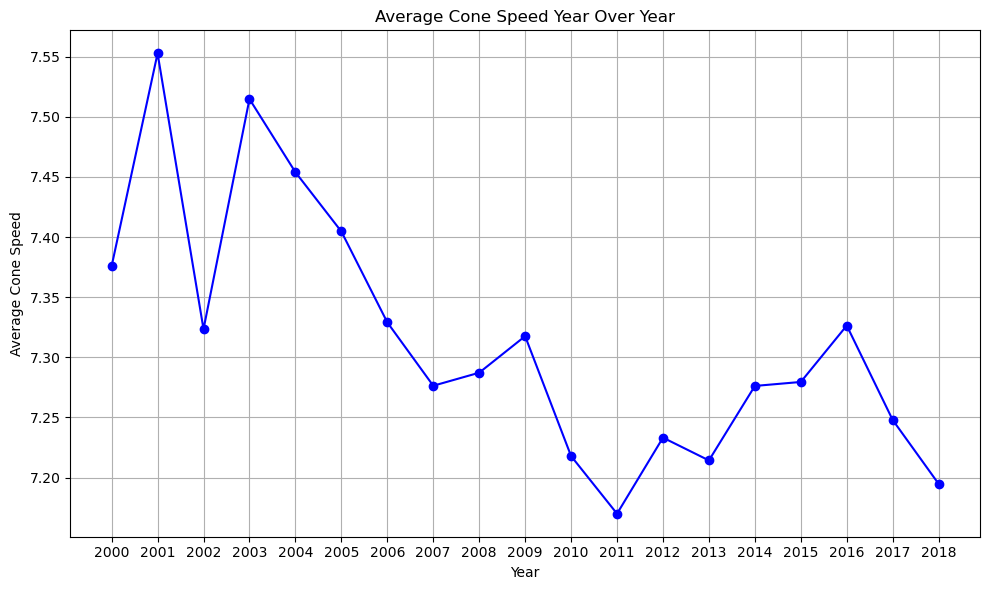

In [38]:
# Group by year and calculate the average cone drill speed for each year
average_cone_speed_yearly = df.groupby('Year')['Cone'].mean()

# Plot the average cone drill speed YOY
plt.figure(figsize=(10, 6))
average_cone_speed_yearly.plot(kind='line', marker='o', color='b')
plt.title('Average Cone Speed Year Over Year')
plt.xlabel('Year')
plt.ylabel('Average Cone Speed')
plt.grid(True)
plt.xticks(average_cone_speed_yearly.index)  # Set x-axis ticks to be the years
plt.tight_layout()
plt.show()

While there does appear to be a dip in the average cone drill speed over time, further analysis is necessary to confirm this trend. We'll begin by fitting a linear regression model to the data. This model will test the following hypotheses:

𝐻0: There is no significant linear relationship between the year of the NFL Combine and the average speed at which players have completed the cone drill from 2000 to 2018.

𝐻𝑎: There is a significant negative linear relationship between the year of the NFL Combine and the average speed at which players have completed the cone drill from 2000 to 2018, indicating that the average speed has decreased during this period.

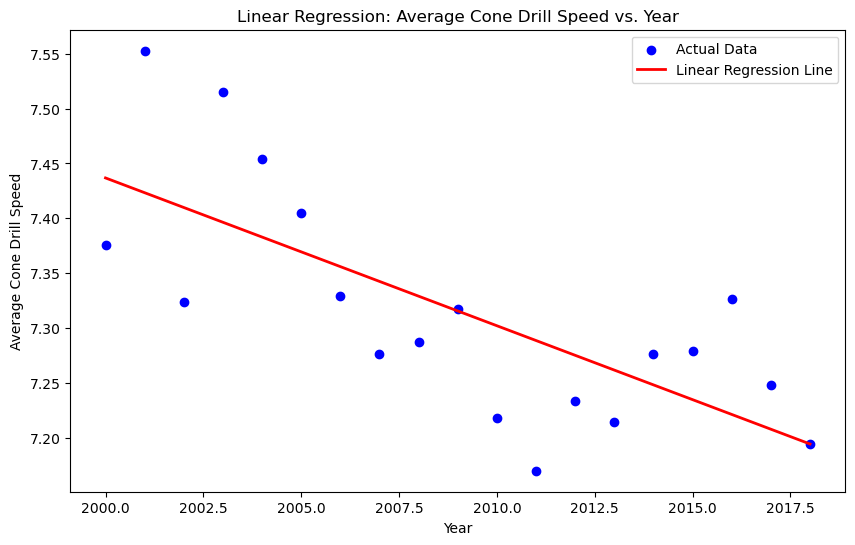

LR Slope: -0.013476126608817912
R-squared (Aggregated Data): 0.5194528023129372


In [39]:

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Reaggregate data by year
yearly_avg_cone_speed = df.groupby('Year')['Cone'].mean().reset_index()

# Extract independent and dependent variables
X = yearly_avg_cone_speed['Year'].values.reshape(-1, 1)  # Independent variable: Year
y = yearly_avg_cone_speed['Cone'].values  # Dependent variable: average Cone drill speed

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the average cone drill speed YOY
predicted_cone_speed = model.predict(X)

# Plot the data points and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, predicted_cone_speed, color='red', linewidth=2, label='Linear Regression Line')
plt.title('Linear Regression: Average Cone Drill Speed vs. Year')
plt.xlabel('Year')
plt.ylabel('Average Cone Drill Speed')
plt.legend()
plt.show()

# Determine the slope (coefficient) of the linear regression model
slope = model.coef_[0]
print("LR Slope:", slope)

# Calculate R-squared
r_squared = r2_score(y, predicted_cone_speed)
print("R-squared (Aggregated Data):", r_squared)

Across all players, the average time to complete the cone drill has been decreasing by about 0.0135 seconds per year. Further, approximately 51.95% of the variance in average cone drill speed can be explained by the year. Let's examine the results of the hypothesis test based on this model.

In [40]:
import numpy as np
from scipy.stats import t

# Number of observations
n = len(X)

# Degrees of freedom
deg = n - 2  # degrees of freedom for a simple linear regression

# Calculate standard error of the slope coefficient
residuals = y - predicted_cone_speed
standard_error_slope = np.sqrt(np.sum(residuals**2) / deg) / np.sqrt(np.sum((X - np.mean(X))**2))

# Calculate t-statistic
t_statistic = slope / standard_error_slope

# Calculate p-value
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), deg))

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -4.286763092593999
p-value: 0.0004989946412297108


The statistically significant t-statistic and small p-value suggest that the relationship between the year of the NFL Combine and the average cone drill speed is significant. Therefore, we reject the null hypothesis and conclude that there is a significant negative linear relationship between Year and average Cone drill speed in our data.

It's important to consider the diversity of player positions within each year of the NFL Combine. A particular draft class might predominantly consist of fast players, resulting in a lower average cone drill time for that year. Conversely, the following draft year might be dominated by slower positions. This positional bias could give the impression that overall player speed changed significantly from year to year, when in reality, it may just reflect the composition of the draft class.

We can run a similar analysis to the one above for each cluster group from 2000 to 2018. In doing so, we mitigate some of the bias introduced by variations in positional subgroups. Let's aggregate the data for each cluster by taking the average cone drill speed each year.

In [41]:
# Aggregate data within each cluster
cluster_1_aggregated = cluster_1.groupby('Year')['Cone'].mean().reset_index()
cluster_2_aggregated = cluster_2.groupby('Year')['Cone'].mean().reset_index()
cluster_3_aggregated = cluster_3.groupby('Year')['Cone'].mean().reset_index()


### Cluster 1 Test


In [42]:
# Extracting data for Cluster 1
X_cluster1 = cluster_1_aggregated['Year'].values.reshape(-1, 1)  # Independent variable: Year
y_cluster1 = cluster_1_aggregated['Cone'].values  # Dependent variable: Average cone drill speed

# Fitting the linear regression model for Cluster 1
model_cluster1 = LinearRegression()
model_cluster1.fit(X_cluster1, y_cluster1)

# Predicting the average cone drill speed for Cluster 1
predicted_cone_speed_cluster1 = model_cluster1.predict(X_cluster1)

# Calculate slope for Cluster 1
slope_cluster1 = model_cluster1.coef_[0]

# Calculate R-squared for Cluster 1
r_squared_cluster1 = r2_score(y_cluster1, predicted_cone_speed_cluster1)

# Calculate standard error of the slope coefficient for Cluster 1
residuals_cluster1 = y_cluster1 - predicted_cone_speed_cluster1
deg_cluster1 = len(X_cluster1) - 2  # degrees of freedom for a simple linear regression
standard_error_slope_cluster1 = np.sqrt(np.sum(residuals_cluster1**2) / deg_cluster1) / np.sqrt(np.sum((X_cluster1 - np.mean(X_cluster1))**2))

# Calculate t-statistic for Cluster 1
t_statistic_cluster1 = slope_cluster1 / standard_error_slope_cluster1

# Calculate p-value for Cluster 1
p_value_cluster1 = 2 * (1 - t.cdf(np.abs(t_statistic_cluster1), deg_cluster1))

# Print results for Cluster 1
print("Cluster 1 Results:")
print("LR Slope:", slope_cluster1)
print("R-squared:", r_squared_cluster1)
print("t-statistic:", t_statistic_cluster1)
print("p-value:", p_value_cluster1)


Cluster 1 Results:
LR Slope: -0.007349373642810325
R-squared: 0.3542425257703843
t-statistic: -3.0537964632802264
p-value: 0.007180695613427712


Similarly for clusters 2 and 3...



In [43]:


# Function to compute regression results for a given cluster
def compute_cluster_results(cluster_data, cluster_name):
    # Extracting data
    X = cluster_data['Year'].values.reshape(-1, 1)  # Independent variable: Year
    y = cluster_data['Cone'].values  # Dependent variable: Average cone drill speed

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predicting the average cone drill speed
    predicted_cone_speed = model.predict(X)

    # Calculate slope
    slope = model.coef_[0]

    # Calculate R-squared
    r_squared = r2_score(y, predicted_cone_speed)

    # Calculate standard error of the slope coefficient
    residuals = y - predicted_cone_speed
    deg = len(X) - 2  # Degrees of freedom
    standard_error_slope = np.sqrt(np.sum(residuals**2) / deg) / np.sqrt(np.sum((X - np.mean(X))**2))

    # Calculate t-statistic
    t_statistic = slope / standard_error_slope

    # Calculate p-value
    p_value = 2 * (1 - t.cdf(np.abs(t_statistic), deg))

    # Print results
    print(f"{cluster_name} Results:")
    print("LR Slope:", slope)
    print("R-squared:", r_squared)
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)
    print()

# Assuming you have cluster_2_aggregated and cluster_3_aggregated datasets
# Compute results for Cluster 2
compute_cluster_results(cluster_2_aggregated, "Cluster 2")

# Compute results for Cluster 3
compute_cluster_results(cluster_3_aggregated, "Cluster 3")

Cluster 2 Results:
LR Slope: -0.0072840259685381685
R-squared: 0.2752515320250436
t-statistic: -2.5409474310335947
p-value: 0.021099052456581502

Cluster 3 Results:
LR Slope: -0.012084404555353465
R-squared: 0.4929295640107907
t-statistic: -4.065207785267011
p-value: 0.0008050992897064013



**Cluster 1:** The average cone drill time for Power Players has been decreasing by approximately 0.0073 seconds each year. The R-squared value of 0.2752 suggests that about 28% of the variance in the average cone drill speed for this cluster can be explained by the year. The negative t-statistic and p-value suggest that there is a significant negative linear relationship between the year of the NFL Combine and the average cone drill speed. Therefore, we reject the null hypothesis and conclude that the average cone drill speed for Power Players has been decreasing over the years.

**Cluster 2:** Agile Players have also seen cone drill performance improve with their average completion time decreasing by approximately 0.0077 seconds each year. An R-squared value of 0.3695 suggests that about 37% of the variance in the average cone drill speed for this cluster can be explained by the year. The negative t-statistic and p-value suggest that there is a significant negative linear relationship between the year of the NFL Combine and the average cone drill speed. Therefore, we reject the null hypothesis and conclude that the average cone drill speed for Agile Players has been decreasing over the years.

**Cluster 3:** Hybrid Players have seen the greatest improvement of all with their average cone drill time decreasing by 0.0119 seconds each year. The R-squared value of 0.4894 suggests that about 49% of the variance in the average cone drill speed for this cluster can be explained by the year. The negative t-statistic and p-value suggest that there is a significant negative linear relationship between the year of the NFL Combine and the average cone drill speed. We again reject the null hypothesis and conclude that the average cone drill speed for Hybrid Players has been decreasing over the years.

To investigate these results further, we will plot all three clusters alongside their regression models for comparison.

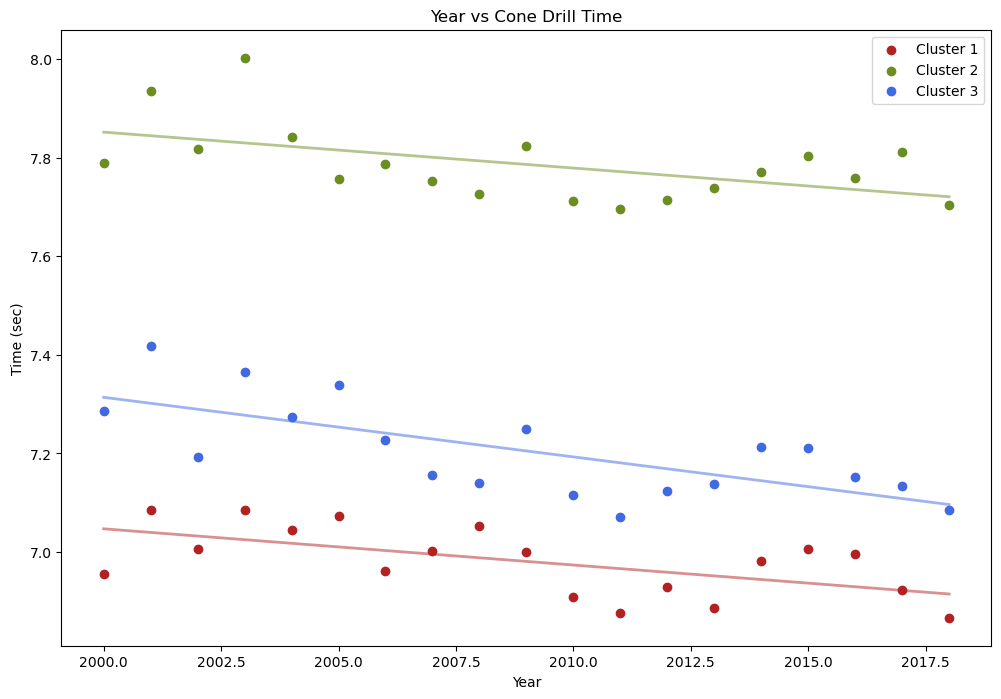

In [44]:
# Function to fit linear regression model and predict
def fit_and_predict(cluster_data):
    X = cluster_data['Year'].values.reshape(-1, 1)
    y = cluster_data['Cone'].values
    model = LinearRegression()
    model.fit(X, y)
    return model, model.predict(X)

# Fit and predict for each cluster
model_cluster1, predicted_cone_speed_cluster1 = fit_and_predict(cluster_1_aggregated)
model_cluster2, predicted_cone_speed_cluster2 = fit_and_predict(cluster_2_aggregated)
model_cluster3, predicted_cone_speed_cluster3 = fit_and_predict(cluster_3_aggregated)

# Generate a year-range for plotting the regression lines
years = np.linspace(df['Year'].min(), df['Year'].max(), 100).reshape(-1, 1)
pred_cluster1_line = model_cluster1.predict(years)
pred_cluster2_line = model_cluster2.predict(years)
pred_cluster3_line = model_cluster3.predict(years)

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(cluster_1_aggregated['Year'], cluster_1_aggregated['Cone'], color='firebrick', label='Cluster 1')
plt.scatter(cluster_2_aggregated['Year'], cluster_2_aggregated['Cone'], color='olivedrab', label='Cluster 2')
plt.scatter(cluster_3_aggregated['Year'], cluster_3_aggregated['Cone'], color='royalblue', label='Cluster 3')

# Plot linear regression lines
plt.plot(years, pred_cluster1_line, color='firebrick', linewidth=2, alpha=0.5)
plt.plot(years, pred_cluster2_line, color='olivedrab', linewidth=2, alpha=0.5)
plt.plot(years, pred_cluster3_line, color='royalblue', linewidth=2, alpha=0.5)

# Labels and legend
plt.xlabel('Year')
plt.ylabel('Time (sec)')
plt.title('Year vs Cone Drill Time')
plt.legend()

plt.show()